# LSTM Chem - Generate

This notebook will develop a stateful LSTM generative model for creating de novo molecules. It will be fed one input character at a time and iteratively sample the next character until the end character "E" is encountered.


In [ ]:
# install rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-06-10 02:56:07--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-06-10 02:56:07--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   194MB/s    in 0.4s    

2020-06-10 02:56:08 (194 MB/s) - ‘Miniconda3-latest-Linux

In [ ]:
# import core libraries 
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.2.0


In [ ]:
# load Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Wed Jun 10 03:00:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [ ]:
# load the model
model_file = '/drive/My Drive/chem_data/LSTM_model.h5'
model = load_model(model_file)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 45)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 309248      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          65664       concatenate[0][0]            

In [ ]:
# create the encoder model from the previously trained model
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 45)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 309248      input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          65664       concatenate[0][0]            

Next, we need to create an intermediary model, one that can decode the latent space into the states that need to be set as inputs to the decoder LSTM cells. A new input, matching the latent space is defined. The model layers from before can be reused to get the h and c states; that way we are able to inherit the weights from the trained model.


In [ ]:
# create a model for mapping from the latent space to the input states of the decoder LSTM model
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          33024       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          33024       input_1[0][0]                    
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
__________________________________________________________________________________________________


Now it's time to create the decoder model. The base model was trained in stateless batch mode; here, we set the decoder model to be stateful so as to predict one character at a time. The layers are defined exactly as before, except with a new batch_shape.

In [ ]:
# define the stateful decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)

In [ ]:
# transfer the weights from the trained model to our generative model
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
gen_model.save("/drive/My Drive/chem_data/gen_model.h5")
gen_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(1, 1, 45)]              0         
_________________________________________________________________
lstm (LSTM)                  (1, 1, 256)               309248    
_________________________________________________________________
dense (Dense)                (1, 1, 45)                11565     
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# define our data load functions
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict  

In [ ]:
# load our Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/drive/My Drive/chem_data/char_to_int.json'
d2 = '/drive/My Drive/chem_data/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

We can play with the temperature of the Softmax activation function during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more invalid molecules. 

In [ ]:
# create our Softmax sampling function 
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

To generate samples from the latent space, we need to compute the h and c states using the latent_to_states_model and then set the initial states of the LSTM generative model. The generative model will be fed one input character at a time and iteratively sample the next character until the end character “E” is encountered.


In [ ]:
# create a function to generate new smiles from the latent space
def sample_smiles(latent, n_vocab, sampling_temp):
    #decode the latent states and set the initial state of the LSTM cells
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define the input character
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # loop to predict the next smiles character
    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence            

Now let's load our test dataset and evaluate how well our model can generate smiles.

In [ ]:
# load our test dataset for assessment of molecule generation
data = '/drive/My Drive/chem_data/test.npy'
test_data = np.load(data)
print(f'Test dataset shape: {test_data.shape}')
print(f'Test data samples:\n {test_data[0:11]}')

Test dataset shape: (87820,)
Test data samples:
 ['Cc1ccc(NC(=O)c2ccncc2Cl)cc1Nc1nc2ccccc2n1-c1cc(N)ncn1'
 'CC(C(=O)NN(C)C(=S)c1ccc(C#N)cc1)C(=O)NN(C)C(=S)c1ccc(C#N)cc1'
 'COCC1CNC(C)CN1CC(=O)N1CC(C)(C)c2cnc(-c3cc4ccccc4o3)cc21'
 'O=C(c1ccc2ccccc2c1)N(CCCN1CCN(CCCNc2ccnc3cc(Cl)ccc23)CC1)CC1CC1'
 'COc1cc2nc(NC(=O)CN3CCN(Cc4ccc(Cl)cc4)CC3)sc2cc1OC'
 'Cc1cncc(-c2cnc(NC3CCN(C)CC3OCC3CCS(=O)(=O)CC3)c3[nH]c(=O)c(C)cc23)c1'
 'CC1CN(c2cccnc2C#N)CCN1C(=O)C12CC3CC(CC(C3)C1)C2'
 'O=C(c1ccc(-c2cccc(NS(=O)(=O)c3ccccc3OC(F)(F)F)c2)s1)c1c(F)ccc(O)c1F'
 'CC(=O)N(C1=C(N2CCCCC2)C(=O)c2ccccc2C1=O)c1cccc(F)c1'
 'COc1cc(-c2ccc3ncc(C(=O)C(C)C)c(Nc4ccc(N5CCNCC5)nc4)c3c2)cc(Cl)c1O'
 'Cc1ncc(C(O)c2c3cc(Cl)cc(C)c3nc3[nH]nc(C)c23)cn1']


In [ ]:
# function to transform our smiles data into a supervised learning dataset
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our test dataset smile input tensor
Xt, _ = vectorize(test_data, 101, n_vocab)
print(f'Sampling dataset input shape: {Xt.shape}')

Sampling dataset input shape: (87820, 100, 45)


Now, we create our latent space for the test dataset using our encoder model.

In [ ]:
# create the latent space from our test dataset
test_latent_space = encoder_model.predict(Xt)
print(f'Test data latent space shape: {test_latent_space.shape}')

Test data latent space shape: (87820, 128)


In [ ]:
# smile generation from our test latent space using a baseline sampling temp
sampling_temp = 1.0
test_smile = sample_smiles(test_latent_space[0:1], n_vocab, sampling_temp)
print('Baseline sampling temp smile generation:')
print(test_smile)
print(test_data[0])

Baseline sampling temp smile generation:
Cc1ccc(NC(=O)c2ccncc2Cl)cc1Nc1nc2ccccc2n1-c1cc(N)ncn1
Cc1ccc(NC(=O)c2ccncc2Cl)cc1Nc1nc2ccccc2n1-c1cc(N)ncn1


In [ ]:
# smile generation from our test latent space using a more aggressive sampling temp
sampling_temp = 1.25
test_smile = sample_smiles(test_latent_space[0:1], n_vocab, sampling_temp)
print(test_smile)
print(test_data[0])

Cc1ccc(NC(=O)c2ccncc2Cl)cc1Nc1nc2ccccc2n1-c1cc(N)ncn1
Cc1ccc(NC(=O)c2ccncc2Cl)cc1Nc1nc2ccccc2n1-c1cc(N)ncn1


In [ ]:
# check percentage of malformed smiles generated using a baseline sampling
sampling_temp = 1.0
wrong = 0
for i in range(100):
    smiles = sample_smiles(test_latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else: 
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100))        

5.0 percent wrongly formatted smiles


In [ ]:
# check percentage of malformed smiles generated using the more agressive 
# sampling temperature
sampling_temp = 1.25
wrong = 0
for i in range(100):
    smiles = sample_smiles(test_latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else: 
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100))  

20.0 percent wrongly formatted smiles


In [ ]:
# load our dataset for creating our smile generation latent space
latent_data = '/drive/My Drive/chem_data/latent_data.csv'
latent = load_data(latent_data)
print(f'Sampling dataset shape: {latent.shape}')
print(f'Sampling data samples:\n {latent[0:11]}')

Sampling dataset shape: (500,)
Sampling data samples:
 ['c1cc(ccc1C(F)(F)F)S(=O)(=O)N2CCN(C[C@@H]2C(=O)NCc3ccc(c(c3)F)OC(F)(F)F)c4nc5c(s4)cnc(n5)C6CC6'
 'C1N(c2nc3nc(C4CC4)ncc3s2)C[C@H](C(NCc2ccc(OC(F)(F)F)c(F)c2)=O)N(S(=O)(c2ccc(C(F)(F)F)cc2)=O)C1'
 'O=S(c1ccc(C(F)(F)F)cc1)(=O)N1[C@@H](C(NCc2cc(F)c(OC(F)(F)F)cc2)=O)CN(c2nc3c(cnc(C4CC4)n3)s2)CC1'
 'C1CN(c2nc3nc(C4CC4)ncc3s2)C[C@H](C(=O)NCc2ccc(OC(F)(F)F)c(F)c2)N1S(c1ccc(C(F)(F)F)cc1)(=O)=O'
 'C1[C@H](C(=O)NCc2ccc(OC(F)(F)F)c(F)c2)N(S(c2ccc(C(F)(F)F)cc2)(=O)=O)CCN1c1sc2c(nc(C3CC3)nc2)n1'
 'C1CN(S(c2ccc(C(F)(F)F)cc2)(=O)=O)[C@@H](C(NCc2ccc(OC(F)(F)F)c(F)c2)=O)CN1c1nc2nc(C3CC3)ncc2s1'
 'O(c1ccc(CNC([C@H]2CN(c3sc4cnc(C5CC5)nc4n3)CCN2S(=O)(c2ccc(C(F)(F)F)cc2)=O)=O)cc1F)C(F)(F)F'
 's1c(N2CCN(S(=O)(=O)c3ccc(C(F)(F)F)cc3)[C@@H](C(NCc3ccc(OC(F)(F)F)c(F)c3)=O)C2)nc2c1cnc(C1CC1)n2'
 'C(F)(F)(Oc1ccc(CNC([C@@H]2N(S(=O)(c3ccc(C(F)(F)F)cc3)=O)CCN(c3nc4nc(C5CC5)ncc4s3)C2)=O)cc1F)F'
 'c1(OC(F)(F)F)ccc(CNC([C@@H]2N(S(=O)(=O)c3ccc(C(F)(F)F)cc3)CCN(c3nc4n

In [ ]:
# create our latent space input tensor
X, _ = vectorize(latent, 101, n_vocab)
print(f'Sampling dataset input shape: {X.shape}')

Sampling dataset input shape: (500, 100, 45)


In [ ]:
# create our latent space for generating molecules using our encoder model
latent_space = encoder_model.predict(X)
print(f'SMILES generating latent space shape: {latent_space.shape}')

SMILES generating latent space shape: (500, 128)


We now create a function to generate smiles molecules around a vector in our latent space.

In [ ]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    if mol:
      mols.append(mol)
      samples.append(out)
  return mols, samples

Let's test our function for generating molecules around a vector in our latent space.

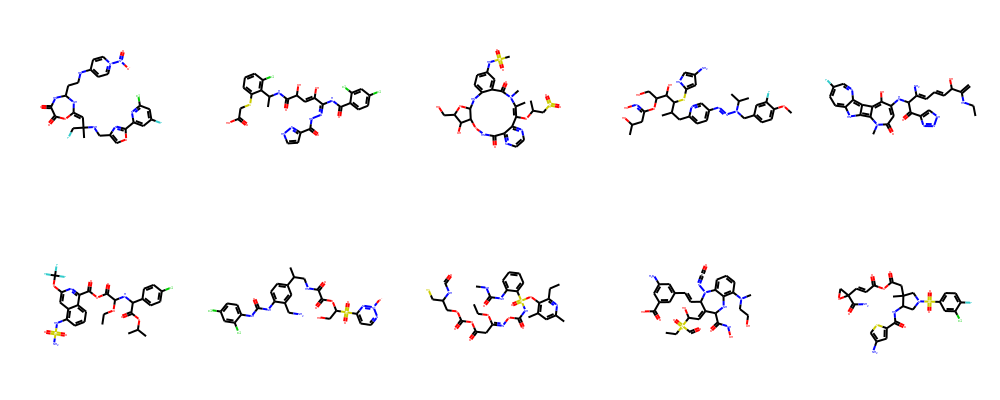

In [ ]:
# generate and plot our generated smiles molecules
latent_seed = latent_space[225:226]
sampling_temp = 0.75
scale = 0.5
quantity = 20
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)
Draw.MolsToGridImage(t_mols, molsPerRow=5)

In [ ]:
print(f'Sampled SMILES:\n {t_smiles}')

Sampled SMILES:
 ['CC(CF)(C=C1OC(=O)C(=O)NC(CCNc2cc[n+]([N+](=O)[O-])cc2)N1)NCc1nc(-c2cc(F)cc(Cl)n2)oc1', 'CC(NC(=O)C(O)C=C(O)C(=NNC(=O)c1cc[nH]n1)NC(=O)c1ccc(Cl)cc1Cl)c1c(Cl)cccc1SCC(=O)O', 'CC(CS(=O)=O)OC1=C(C)N(C)C(=O)c2cc(NS(=O)(=O)C)ccc2NC2OC(CO)C(O)C2ONC(=O)c2nccnc21', 'CC(CC(=NO)OC(CO)C(O)C(Sc1cc(N)c[nH]1)C(C)Cc1ccc(N=NN(Cc2ccc(OC)c(F)c2)C(C)C)cn1)O', 'CCNC(=C)C(O)C=CC=C(N)C(C(=O)c1c[nH]nn1)Nc1c(O)c2c(c3[nH]c4ccc(F)cnc4c32)n(C)c(=O)c1', 'CCOC(C(=O)OC(=O)c1nc(OC(F)(F)F)cc2c(NS(=O)(=O)N)cccc12)NC(c1ccc(Cl)cc1)C(=O)OC(C)C', 'CC(CNC(=O)C(=O)OC(CO)S(=O)(=O)c1ccn[n+]([O-])n1)c1ccc(NC(=O)Nc2ccc(Cl)cc2Cl)c(CN)c1', 'CCOC(CC(=O)OC(=O)OCC(CS)NC=O)=NOC(=O)NS(=O)(c1ccccc1NC(=O)NC)Oc1c(C)cc(C)nc1CC', 'CCS(=O)(C=O)C(O)C=C1C(C(=O)NO)Nc2c(N(C)CCO)cccc2N(N=C=O)C1C=Cc1cc(N)cc(C(=O)O)c1', 'CC1(CC(=O)OC(=O)C=CC2(C(N)=O)OC2)CN(S(=O)(=O)c2ccc(F)c(Cl)c2)CC1NC(=O)c1cc(N)cs1']


In [ ]:
# generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
for i in range(latent.shape[0] - 1):
  latent_seed = latent_space[i:i+1]
  sampling_temp = rn.uniform(0.5, 1.2)
  scale = 0.5
  quantity = 25
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

SMILES generation completed!


In [ ]:
print(f'Number of generated molecules: {len(gen_mols)}')
print(f'Number of generated smiles: {len(gen_smiles)}')
print(f'Generated SMILES:\n {gen_smiles}')

Number of generated molecules: 1925
Number of generated smiles: 1925
Generated SMILES:
 ['c1cc(-c2cc(C(F)F)n(N)n2)c(C(=O)NC(=O)C(C)(C)O)c(-c2ccc3c(c2)CCN(C(=O)N2CCCC2)CC(=O)NC3)c1C', 'COCc1cc(CC(=O)N(S(=O)(=O)CN(C)C)C(C)C(=O)NC(=O)Nc2ccc(F)cc2Cl)sc1C(=O)NCC1CCC2(OC1)C(C)CC2', 'C1N(C2CNC3CCCN3CCC2c2c3c([S+](C)[nH]cc3-c3ccn(C(F)(F)F)c3)c(=O)[nH]c2C(C=O)OCC(F)(F)F)OOCC1=O', 'CNc1nc(-c2nC3CCCN3CCc3c(cc(C(C)(C)C)c(O)c3)C2)c(S(=O)(=O)Nc2c(Cl)c(OC(F)(F)F)cc(Cl)c2Cl)cc1O', 'CN1OC(C)CC1CN1CC2CCC1c1c(C)n(C(CC(=O)O)c3ccc([N+](=O)[O-])c(F)c3)c(=O)n1C(=O)C(O)C(CO)(C#N)C2', 'O=C(Nc1cc[n+]([O-])cc1N(c1c(C(F)(F)CN(C#N)OP(=O)(O)O)cn1)C1CCOCC1)OC(CO)CC(C#N)=CCC1CCCO1', 'O=S(c1=O)[nH]n1-c1c(O)[nH]nc1S(=O)(=O)C(Cc1c[nH]c2c(Cl)cccc12)C(=O)NC(CC1CCO1)C1CCN(C2CC2)C1', 'CCOC1(CCN2CCC(n3c(-c4cnsc4C)[n+](CC(C)c4cccc(F)c4)[n+]([O-])c(C)c(F)c3[N+](=O)[O-])cc2)C(C)C1=O', 'CCNC1(c2nc3noc(-c4sccn4)c32)CC(S(=O)(=O)C(c2cccc(C(F)(F)F)c2)[N+](=O)[O-])OC(O)C(O)(C(F)F)C1O', 'CC[N+](CC=[S-])c1ccc(C#N)c(C(=O)O[N+](N)(N)Nc2c

In [ ]:
# save the generated smiles list
outfile = '/drive/My Drive/chem_data/generated_smiles_v3.csv'
with open(outfile, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')

SMILES saved
